In [1]:
# INSTALL REQUIRED LIBRARIES
%pip install resampy librosa


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
#IMPORT LIBRARIES
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime


In [3]:
#LOAD METADATA & SET PATHS
audio_dataset_path = 'C:/Users/koush/Downloads/UrbanSound8K/audio'
metadata = pd.read_csv('C:/Users/koush/Downloads/UrbanSound8K/metadata/UrbanSound8K.csv')


In [4]:
#FEATURE EXTRACTION FUNCTION (MEAN + STD)
def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_mean = np.mean(mfccs_features.T, axis=0)
    mfccs_scaled_std = np.std(mfccs_features.T, axis=0)
    mfccs_combined = np.hstack((mfccs_scaled_mean, mfccs_scaled_std))
    return mfccs_combined  # shape = (80,)


In [5]:
#EXTRACT FEATURES FROM ALL FILES
extracted_features = []
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), 'fold' + str(row["fold"]), row["slice_file_name"])
    final_class_labels = row["class"]
    data = features_extractor(file_name)
    extracted_features.append([data, final_class_labels])


0it [00:00, ?it/s]C:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
3555it [04:21, 13.92it/s]C:\Users\koush\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=13

In [6]:
#CONVERT TO DATAFRAME AND ENCODE LABELS
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])

x = np.array(extracted_features_df['feature'].tolist())
y_labels = extracted_features_df['class'].tolist()

y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y_labels)
y = to_categorical(y_encoded)  # One-hot encoding


In [7]:
#SPLIT AND NORMALIZE FEATURES
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [8]:
#BUILD MODEL
model = Sequential()
model.add(Dense(100, input_shape=(80,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


C:\Users\koush\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100)                 │           8,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,410 (193.01 KB)

 Trainable params: 49,410 (193.01 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# OPTIONAL: Learning rate scheduler (reduce LR if val_loss plateaus)
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, 
                                 patience=5, 
                                 verbose=1, 
                                 min_lr=1e-6)


In [13]:
from tensorflow.keras.callbacks import Callback

class TestAccuracyCallback(Callback):
    def __init__(self, x_test, y_test):
        self.x_test = x_test
        self.y_test = y_test
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        self.test_accuracies.append(test_acc)
        print(f" Epoch {epoch + 1}: Test Accuracy = {test_acc:.4f}")



In [14]:
# TRAIN MODEL WITH CHECKPOINTS AND EARLY STOPPING
checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.keras', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start = datetime.now()
test_acc_callback = TestAccuracyCallback(x_test, y_test)

# Store training history for plotting
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpointer, earlystop, lr_scheduler, test_acc_callback])

duration = datetime.now() - start
print("Training completed in time:", duration)


Epoch 1/100
214/219 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9065 - loss: 0.2957
Epoch 1: val_loss improved from inf to 0.26362, saving model to saved_models/audio_classification.keras
 Epoch 1: Test Accuracy = 0.9136
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9065 - loss: 0.2954 - val_accuracy: 0.9136 - val_loss: 0.2636 - learning_rate: 3.1250e-05
Epoch 2/100
208/219 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9056 - loss: 0.2963
Epoch 2: val_loss improved from 0.26362 to 0.26307, saving model to saved_models/audio_classification.keras
 Epoch 2: Test Accuracy = 0.9141
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9057 - loss: 0.2958 - val_accuracy: 0.9141 - val_loss: 0.2631 - learning_rate: 3.1250e-05
Epoch 3/100
207/219 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9058 - loss: 0.2786
Epoch 3: val_loss did not improve from 0.26307
 Epoch 3: Test Accuracy = 0.9147
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9060 - loss: 0.2787 - val_accuracy: 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 Test Accuracy: 0.9141
 Final Training Accuracy: 0.9101
 Final Validation Accuracy: 0.9147


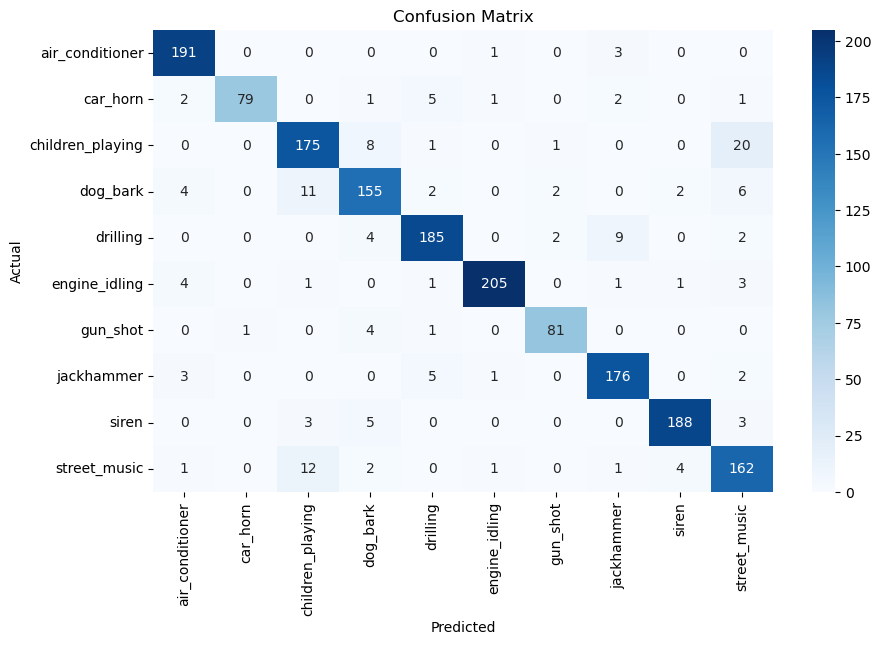


 Per-Class Report:
                  precision    recall  f1-score   support

 air_conditioner       0.93      0.98      0.95       195
        car_horn       0.99      0.87      0.92        91
children_playing       0.87      0.85      0.86       205
        dog_bark       0.87      0.85      0.86       182
        drilling       0.93      0.92      0.92       202
   engine_idling       0.98      0.95      0.96       216
        gun_shot       0.94      0.93      0.94        87
      jackhammer       0.92      0.94      0.93       187
           siren       0.96      0.94      0.95       199
    street_music       0.81      0.89      0.85       183

        accuracy                           0.91      1747
       macro avg       0.92      0.91      0.92      1747
    weighted avg       0.92      0.91      0.91      1747



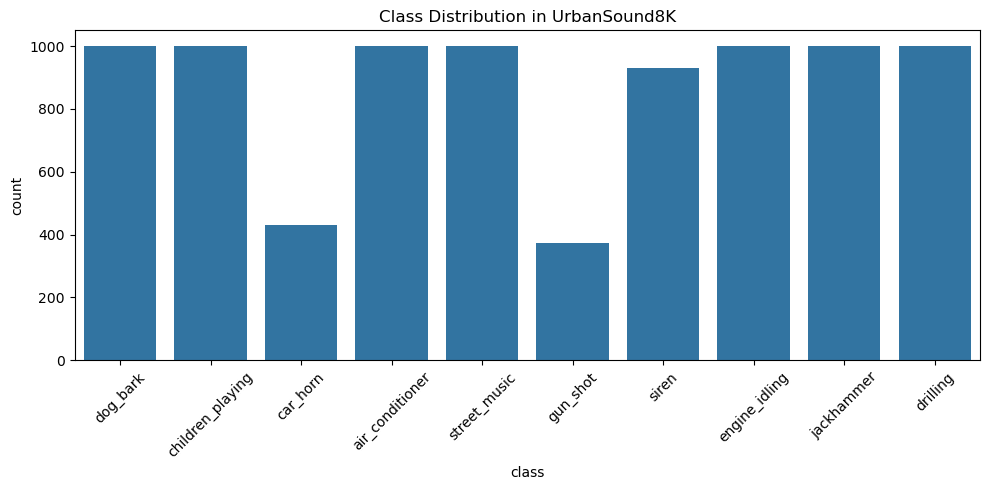

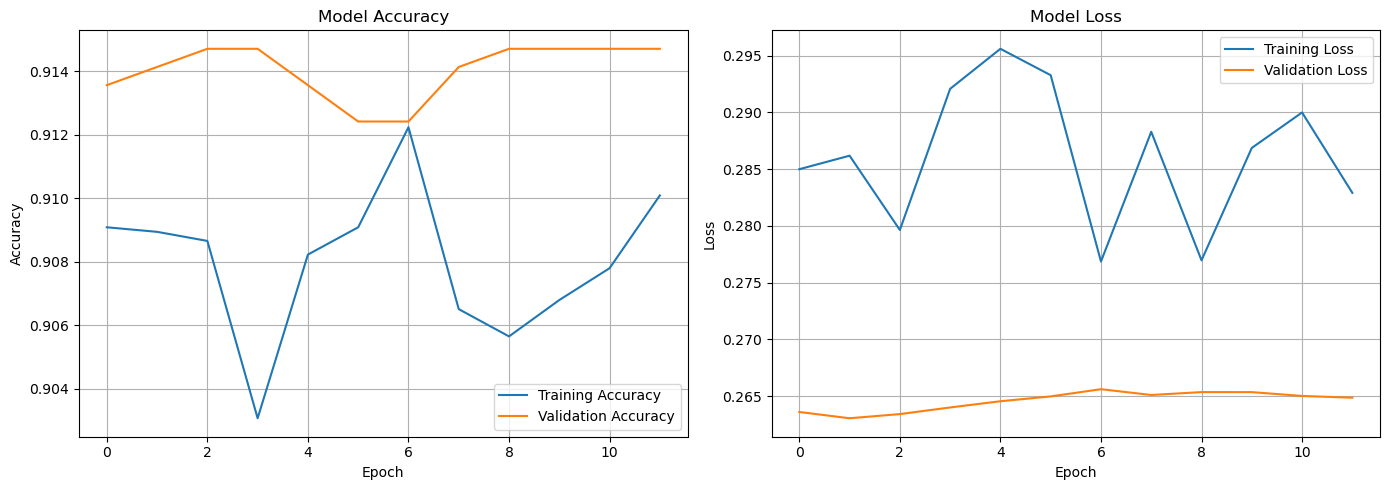

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on test data
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 1. Test Accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\n Test Accuracy: {test_accuracy:.4f}")

# Get final training accuracy
final_train_accuracy = history.history['accuracy'][-1]

# Get final validation accuracy
final_val_accuracy = history.history['val_accuracy'][-1]

# Print them
print(f" Final Training Accuracy: {final_train_accuracy:.4f}")
print(f" Final Validation Accuracy: {final_val_accuracy:.4f}")

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#3. Per-Class Precision, Recall, F1-Score
print("\n Per-Class Report:")
print(classification_report(y_true, y_pred, target_names=y_encoder.classes_))

# Bar plot of sample counts per class
plt.figure(figsize=(10, 5))
sns.countplot(x='class', data=metadata)
plt.title("Class Distribution in UrbanSound8K")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


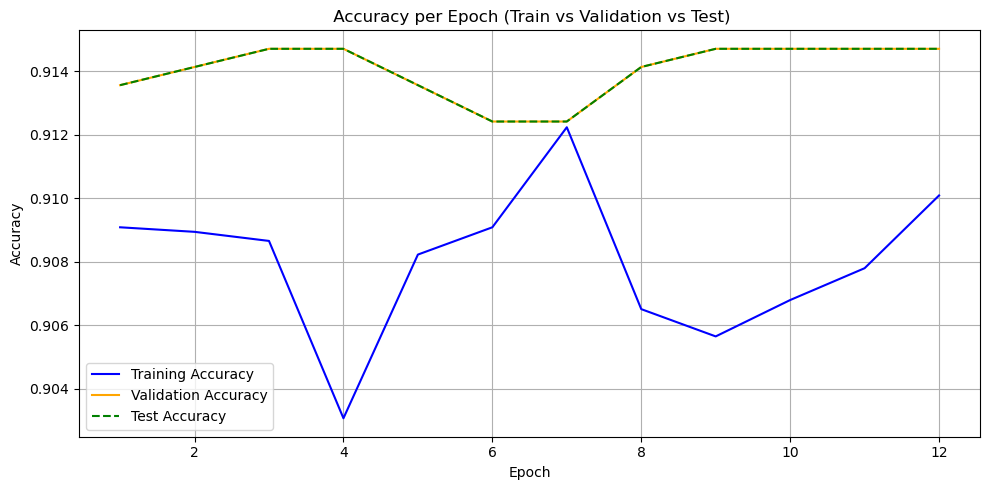

In [23]:
#  Plot All Three Accuracies
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.plot(epochs, test_acc_callback.test_accuracies, label='Test Accuracy', color='green', linestyle='--')

plt.title(" Accuracy per Epoch (Train vs Validation vs Test)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
# PREDICT CUSTOM AUDIO FILE
custom_file = "C:/Users/koush/Downloads/UrbanSound8K/one.wav" # Add Audio file here
audio, sample_rate = librosa.load(custom_file, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_mean = np.mean(mfccs_features.T, axis=0)
mfccs_scaled_std = np.std(mfccs_features.T, axis=0)
mfccs_combined = np.hstack((mfccs_scaled_mean, mfccs_scaled_std)).reshape(1, -1)
mfccs_combined = scaler.transform(mfccs_combined)

prediction_probs = model.predict(mfccs_combined)
predicted_label = np.argmax(prediction_probs, axis=1)
predicted_class = y_encoder.inverse_transform(predicted_label)
print("Predicted class:", predicted_class[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted class: car_horn
